In [28]:
import numpy as np
np.set_printoptions(suppress = True)
from importlib import reload
import functions
from functions import *
functions = reload(functions)

In [29]:
b = 3
qasm_qc = QuantumCircuit(b, b)
QFT(qasm_qc, b, delta=8)
qasm_output = qasm_qc.qasm()

In [30]:
with open("qasm_files/qasm{}qubit".format(b), 'w') as txt_file:
    txt_file.write(qasm_output)

In [31]:
n_low = 2
n_high = 6
compareFTs(n_low, n_high, backend="statevector", display_bool=False)

errors2-6.txt
n=2, i=0
progress: 50.00%
--- 0.012s seconds ---
n=3, i=1
progress: 33.33%
progress: 66.67%
--- 0.040s seconds ---
n=4, i=2
progress: 25.00%
progress: 50.00%
progress: 75.00%
--- 0.095s seconds ---
n=5, i=3
progress: 20.00%
progress: 40.00%
progress: 60.00%
progress: 80.00%
--- 0.179s seconds ---
n=6, i=4
progress: 16.67%
progress: 33.33%
progress: 50.00%
progress: 66.67%
progress: 83.33%
--- 0.303s seconds ---


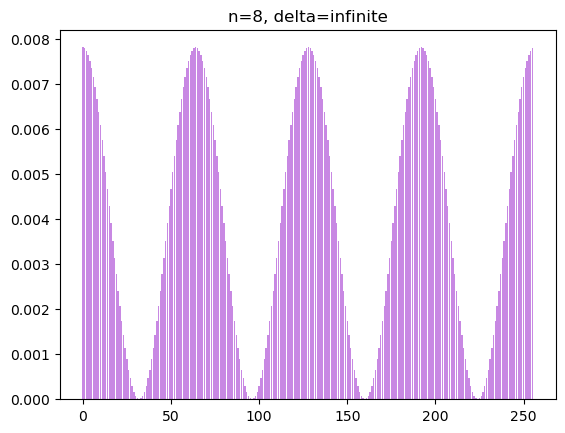

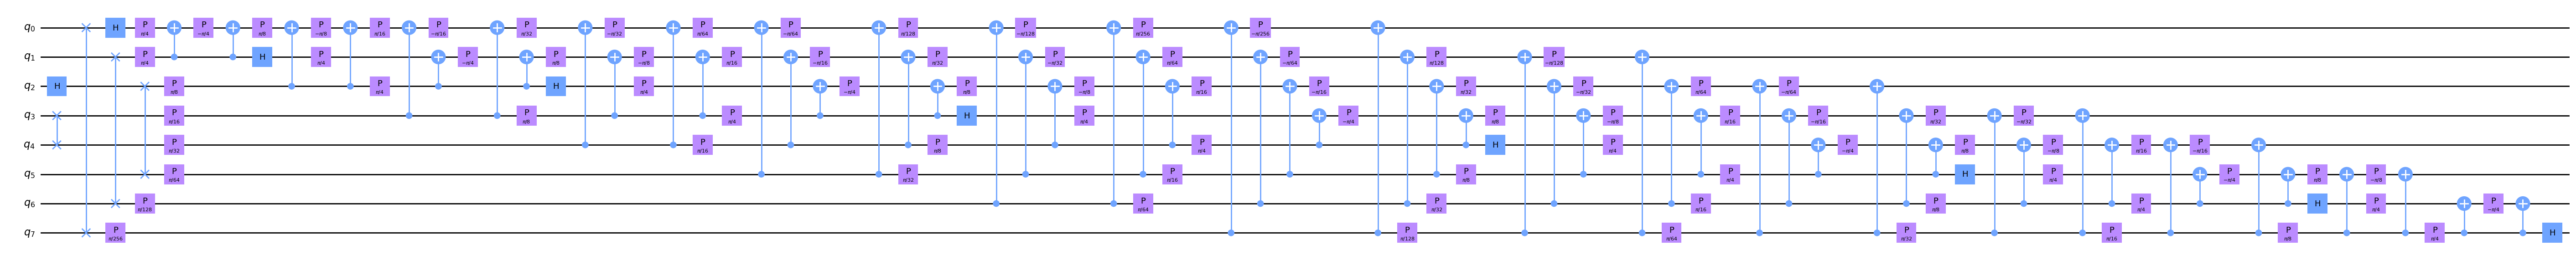

<Figure size 640x480 with 0 Axes>

In [32]:
n = 8
ac = QuantumCircuit(n)
ac.h(2)
QFT(ac, n)

probs = simulateQFT(ac, n, display_bool=True)

ac.draw(output="mpl", fold=-1)

min_n = 4, max_n = 13, min_d = 1, max_d = 12
(13, 12)
x = 4, y = 1, data = 0.03125000000000003
x = 4, y = 2, data = 3.469446951953614e-18
x = 4, y = 3, data = 6.938893903907228e-18
x = 5, y = 1, data = 0.023437500000000014
x = 5, y = 2, data = 0.007812500000000014
x = 5, y = 3, data = 3.7947076036992655e-18
x = 5, y = 4, data = 5.095750210681871e-18
x = 6, y = 1, data = 0.01171875000000001
x = 6, y = 2, data = 0.003906250000000007
x = 6, y = 3, data = 5.8817967857338616e-18
x = 6, y = 4, data = 6.152847328855238e-18
x = 6, y = 5, data = 1.734723475976807e-18
x = 7, y = 1, data = 0.006835937500000006
x = 7, y = 2, data = 0.002929687500000008
x = 7, y = 3, data = 0.0009765625000000043
x = 7, y = 4, data = 2.930733997499879e-18
x = 7, y = 5, data = 1.9786689647860456e-18
x = 7, y = 6, data = 1.2536087619363645e-18
x = 8, y = 1, data = 0.003417968750000003
x = 8, y = 2, data = 0.0014648437500000043
x = 8, y = 3, data = 0.0004882812500000015
x = 8, y = 4, data = 2.383127197099974e-18
x = 8,

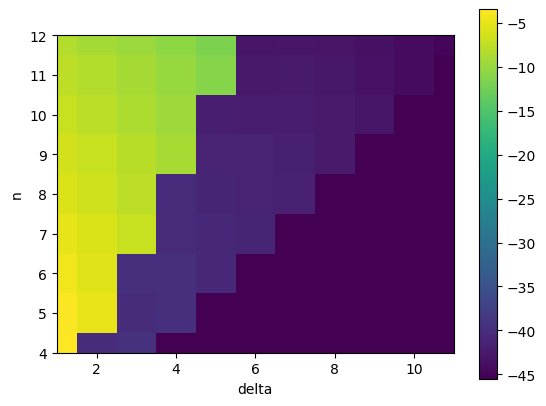

In [115]:
plotErrorsFromFile("txt/errors4-12.txt")

In [43]:
from qiskit import QuantumRegister, ClassicalRegister
def twoBitCarry():
    no_qubits = 4
    qr = QuantumRegister(no_qubits)
    qc = QuantumCircuit(qr, name="2-bit carry")
    """
        -- anc1
        -- a
        -- b
        -- anc2
    """
    anc1, a, b, anc2 = [qr[i] for i in range(no_qubits)]

    qc.toffoli(a, b, anc2)
    qc.cnot(a, b)
    qc.toffoli(anc1, b, anc2)
    return qc.to_instruction()



                       
q226_0: ──■────────────
          │            
q226_1: ──┼────■────■──
          │  ┌─┴─┐  │  
q226_2: ──■──┤ X ├──■──
        ┌─┴─┐└───┘┌─┴─┐
q226_3: ┤ X ├─────┤ X ├
        └───┘     └───┘
           ┌──────────────────────┐   ┌─┐         
qr_0: ─────┤0                     ├───┤M├─────────
      ┌───┐│                      │   └╥┘┌─┐      
qr_1: ┤ X ├┤1                     ├────╫─┤M├──────
      └───┘│  2-bit reverse carry │    ║ └╥┘┌─┐   
qr_2: ─────┤2                     ├────╫──╫─┤M├───
           │                      │    ║  ║ └╥┘┌─┐
qr_3: ─────┤3                     ├────╫──╫──╫─┤M├
           └─────────┬─┬──────────┘    ║  ║  ║ └╥┘
qr_4: ───────────────┤M├───────────────╫──╫──╫──╫─
      ┌───┐          └╥┘           ┌─┐ ║  ║  ║  ║ 
qr_5: ┤ X ├───────────╫────────────┤M├─╫──╫──╫──╫─
      └┬─┬┘           ║            └╥┘ ║  ║  ║  ║ 
qr_6: ─┤M├────────────╫─────────────╫──╫──╫──╫──╫─
       └╥┘            ║             ║  ║  ║  ║  ║ 
cr_0: ══╬══════════